# Imports

In [1]:
import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
from cbrain.climate_invariant import *

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_probability as tfp
import xarray as xr
import numpy as np

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
import matplotlib.ticker as mticker
import matplotlib.transforms as mtrans
import matplotlib.pylab as plb
# from mpl_toolkits.basemap import Basemap
# bm = Basemap()

import pickle
# from climate_invariant import *
from tensorflow.keras import layers
import datetime
from climate_invariant_utils import *
import yaml


/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


# Global variables and Data Generators

## Global variables

In [2]:
# Load coordinates (just pick any file from the climate model run)

# Comet path below
# coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
#                     decode_times=False)

# GP path below
path_0K = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/'
coor = xr.open_dataset(path_0K+"AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-09-02-00000.nc")

lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [3]:
# Comet path below
# TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData/'
# path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'

# GP path below
TRAINDIR = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path = '/export/nfs0home/tbeucler/CBRAIN-CAM/cbrain/'
path_nnconfig = '/export/nfs0home/tbeucler/CBRAIN-CAM/nn_config/'

# Load hyam and hybm to calculate pressure field in SPCAM
path_hyam = 'hyam_hybm.pkl'
hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)

# Scale dictionary to convert the loss to W/m2
scale_dict = load_pickle(path_nnconfig+'scale_dicts/009_Wm2_scaling.pkl')

## Data Generators

### Choose between aquaplanet and realistic geography here

In [4]:
# GP paths below
#path_aquaplanet = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
#path_realgeography = ''

# GP /fast paths below
path_aquaplanet = '/fast/tbeucler/climate_invariant/aquaplanet/'

# Comet paths below
# path_aquaplanet = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'
# path_realgeography = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/geography/'

path = path_aquaplanet

### Data Generator using RH

In [5]:
#scale_dict_RH = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling_2.pkl')
scale_dict_RH = scale_dict.copy()
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
# if path==path_realgeography: out_vars_RH = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']
# elif path==path_aquaplanet: out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
if path==path_aquaplanet: out_vars_RH = ['PHQ','TPHYSTND','QRL','QRS']

# New GP path below
TRAINFILE_RH = '2021_01_24_O3_small_shuffle.nc'
NORMFILE_RH = '2021_02_01_NORM_O3_RH_small.nc'
    
# Comet/Ankitesh path below
# TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
# NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
# VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'

In [6]:
train_gen_RH = DataGenerator(
    data_fn = path+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = path+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using QSATdeficit

We only need the norm file for this generator as we are solely using it as an input to determine the right normalization for the combined generator

In [7]:
# New GP path below
TRAINFILE_QSATdeficit = '2021_02_01_O3_QSATdeficit_small_shuffle.nc'
NORMFILE_QSATdeficit = '2021_02_01_NORM_O3_QSATdeficit_small.nc'

In [8]:
in_vars_QSATdeficit = ['QSATdeficit','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
# if path==path_realgeography: out_vars_RH = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']
# elif path==path_aquaplanet: out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
if path==path_aquaplanet: out_vars_QSATdeficit = ['PHQ','TPHYSTND','QRL','QRS']

In [9]:
train_gen_QSATdeficit = DataGenerator(
    data_fn = path+TRAINFILE_QSATdeficit,
    input_vars = in_vars_QSATdeficit,
    output_vars = out_vars_QSATdeficit,
    norm_fn = path+NORMFILE_QSATdeficit,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using TNS

In [10]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_TNS = '2021_02_01_O3_TfromNS_small_shuffle.nc'
NORMFILE_TNS = '2021_02_01_NORM_O3_TfromNS_small.nc'
VALIDFILE_TNS = 'CI_TNS_M4K_NORM_valid.nc'

In [11]:
train_gen_TNS = DataGenerator(
    data_fn = path+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using BCONS

In [12]:
in_vars = ['QBP','BCONS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_BCONS = '2021_02_01_O3_BCONS_small_shuffle.nc'
NORMFILE_BCONS = '2021_02_01_NORM_O3_BCONS_small.nc'

In [13]:
train_gen_BCONS = DataGenerator(
    data_fn = path+TRAINFILE_BCONS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_BCONS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using BMSE

In [14]:
in_vars = ['QBP','BMSE','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_BMSE = '2021_06_16_BMSE_small_shuffle.nc'
NORMFILE_BMSE = '2021_06_16_NORM_BMSE_small.nc'

In [15]:
train_gen_BMSE = DataGenerator(
    data_fn = path+TRAINFILE_BMSE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_BMSE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using NSto220

In [16]:
in_vars = ['QBP','T_NSto220','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_T_NSto220 = '2021_03_31_O3_T_NSto220_small.nc'
NORMFILE_T_NSto220 = '2021_03_31_NORM_O3_T_NSto220_small.nc'

In [17]:
train_gen_T_NSto220 = DataGenerator(
    data_fn = path+TRAINFILE_T_NSto220,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_T_NSto220,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True,
)

### Data Generator using LHF_nsDELQ

In [18]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHF_nsDELQ']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_LHF_nsDELQ = '2021_02_01_O3_LHF_nsDELQ_small_shuffle.nc'
NORMFILE_LHF_nsDELQ = '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'

In [19]:
train_gen_LHF_nsDELQ = DataGenerator(
    data_fn = path+TRAINFILE_LHF_nsDELQ,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_LHF_nsDELQ,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True,
)

### Data Generator using LHF_nsQ

In [20]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHF_nsQ']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_LHF_nsQ = '2021_02_01_O3_LHF_nsQ_small_shuffle.nc'
NORMFILE_LHF_nsQ = '2021_02_01_NORM_O3_LHF_nsQ_small.nc'

In [21]:
train_gen_LHF_nsQ = DataGenerator(
    data_fn = path+TRAINFILE_LHF_nsQ,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_LHF_nsQ,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True,
)

### Data Generator Combined (latest flexible version)

In [71]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
#if path==path_aquaplanet: out_vars=['PHQPERC','TPHYSTNDPERC','QRLPERC','QRSPERC']
out_vars = ['PHQ','TPHYSTND','QRL','QRS']

In [72]:
# TRAINFILE = '2021_01_24_O3_TRAIN_shuffle.nc'
NORMFILE = '2021_01_24_NORM_O3_small.nc'
# VALIDFILE = '2021_01_24_O3_VALID.nc'
# GENTESTFILE = 'CI_SP_P4K_valid.nc'

# In physical space
TRAINFILE = '2021_03_18_O3_TRAIN_M4K_shuffle.nc'
VALIDFILE = '2021_03_18_O3_VALID_M4K.nc'
TESTFILE_DIFFCLIMATE = '2021_03_18_O3_TRAIN_P4K_shuffle.nc'
TESTFILE_DIFFGEOG = '2021_04_18_RG_TRAIN_M4K_shuffle.nc'

# In percentile space
#TRAINFILE = '2021_04_09_PERC_TRAIN_M4K_shuffle.nc'
#TRAINFILE = '2021_01_24_O3_small_shuffle.nc'
#VALIDFILE = '2021_04_09_PERC_VALID_M4K.nc'
#TESTFILE = '2021_04_09_PERC_TEST_P4K.nc'

Old data generator by Ankitesh

Improved flexible data generator

In [73]:
train_gen_BF = DataGeneratorCI(data_fn = path+TRAINFILE,
                               input_vars=in_vars,
                               output_vars=out_vars,
                               norm_fn=path+NORMFILE,
                               input_transform=('mean', 'maxrs'),
                               output_transform=scale_dict,
                               batch_size=8192,
                               shuffle=True,
                               xarray=False,
                               var_cut_off=None, 
                               Qscaling=None,
                               Tscaling=None,
                               LHFscaling=None,
                               SHFscaling=None,
                               output_scaling=False,
                               interpolate=False,
                               hyam=hyam,hybm=hybm,
                               inp_sub_Qscaling=None,
                               inp_div_Qscaling=None,
                               inp_sub_Tscaling=None,
                               inp_div_Tscaling=None,
                               inp_sub_LHFscaling=None,
                               inp_div_LHFscaling=None,
                               inp_sub_SHFscaling=None,
                               inp_div_SHFscaling=None,
                               lev=None, interm_size=40,
                               lower_lim=6,is_continous=True,Tnot=5,
                               epsQ=1e-3,epsT=1,mode='train')

In [74]:
valid_gen_BF = DataGeneratorCI(data_fn = path+VALIDFILE,
                               input_vars=in_vars,
                               output_vars=out_vars,
                               norm_fn=path+NORMFILE,
                               input_transform=('mean', 'maxrs'),
                               output_transform=scale_dict,
                               batch_size=8192,
                               shuffle=True,
                               xarray=False,
                               var_cut_off=None, 
                               Qscaling=None,
                               Tscaling=None,
                               LHFscaling=None,
                               SHFscaling=None,
                               output_scaling=False,
                               interpolate=False,
                               hyam=hyam,hybm=hybm,
                               inp_sub_Qscaling=None,
                               inp_div_Qscaling=None,
                               inp_sub_Tscaling=None,
                               inp_div_Tscaling=None,
                               inp_sub_LHFscaling=None,
                               inp_div_LHFscaling=None,
                               inp_sub_SHFscaling=None,
                               inp_div_SHFscaling=None,
                               lev=None, interm_size=40,
                               lower_lim=6,is_continous=True,Tnot=5,
                               epsQ=1e-3,epsT=1,mode='train')

In [75]:
test_diffclimate_gen_BF = DataGeneratorCI(data_fn = path+TESTFILE_DIFFCLIMATE,
                                       input_vars=in_vars,
                                       output_vars=out_vars,
                                       norm_fn=path+NORMFILE,
                                       input_transform=('mean', 'maxrs'),
                                       output_transform=scale_dict,
                                       batch_size=8192,
                                       shuffle=True,
                                       xarray=False,
                                       var_cut_off=None, 
                                       Qscaling=None,
                                       Tscaling=None,
                                       LHFscaling=None,
                                       SHFscaling=None,
                                       output_scaling=False,
                                       interpolate=False,
                                       hyam=hyam,hybm=hybm,
                                       inp_sub_Qscaling=None,
                                       inp_div_Qscaling=None,
                                       inp_sub_Tscaling=None,
                                       inp_div_Tscaling=None,
                                       inp_sub_LHFscaling=None,
                                       inp_div_LHFscaling=None,
                                       inp_sub_SHFscaling=None,
                                       inp_div_SHFscaling=None,
                                       lev=None, interm_size=40,
                                       lower_lim=6,is_continous=True,Tnot=5,
                                       epsQ=1e-3,epsT=1,mode='train')

In [76]:
test_diffgeog_gen_BF = DataGeneratorCI(data_fn = path+TESTFILE_DIFFGEOG,
                                       input_vars=in_vars,
                                       output_vars=out_vars,
                                       norm_fn=path+NORMFILE,
                                       input_transform=('mean', 'maxrs'),
                                       output_transform=scale_dict,
                                       batch_size=8192,
                                       shuffle=True,
                                       xarray=False,
                                       var_cut_off=None, 
                                       Qscaling=None,
                                       Tscaling=None,
                                       LHFscaling=None,
                                       SHFscaling=None,
                                       output_scaling=False,
                                       interpolate=False,
                                       hyam=hyam,hybm=hybm,
                                       inp_sub_Qscaling=None,
                                       inp_div_Qscaling=None,
                                       inp_sub_Tscaling=None,
                                       inp_div_Tscaling=None,
                                       inp_sub_LHFscaling=None,
                                       inp_div_LHFscaling=None,
                                       inp_sub_SHFscaling=None,
                                       inp_div_SHFscaling=None,
                                       lev=None, interm_size=40,
                                       lower_lim=6,is_continous=True,Tnot=5,
                                       epsQ=1e-3,epsT=1,mode='train')

### Climate-invariant data generator

In [69]:
path = path_aquaplanet

In [70]:
Tscaling_name = 'BMSE'
train_gen_T = train_gen_BMSE

train_gen_CI_BCONS = DataGeneratorCI(data_fn = path+TRAINFILE,
                               input_vars=in_vars,
                               output_vars=out_vars,
                               norm_fn=path+NORMFILE,
                               input_transform=('mean', 'maxrs'),
                               output_transform=None,
                               batch_size=8192,
                               shuffle=True,
                               xarray=False,
                               var_cut_off=None, 
                               Qscaling='RH',
                               Tscaling=Tscaling_name,
                               LHFscaling='LHF_nsDELQ',
                               SHFscaling=None,
                               output_scaling=False,
                               interpolate=False,
                               hyam=hyam,hybm=hybm,
                               inp_sub_Qscaling=train_gen_RH.input_transform.sub,
                               inp_div_Qscaling=train_gen_RH.input_transform.div,
                               inp_sub_Tscaling=train_gen_T.input_transform.sub,
                               inp_div_Tscaling=train_gen_T.input_transform.div,
                               inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
                               inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div,
                               inp_sub_SHFscaling=None,
                               inp_div_SHFscaling=None,
                               lev=None, interm_size=40,
                               lower_lim=6,is_continous=True,Tnot=5,
                               epsQ=1e-3,epsT=1,mode='train')

valid_gen_CI_BCONS = DataGeneratorCI(data_fn = path+VALIDFILE,
                               input_vars=in_vars,
                               output_vars=out_vars,
                               norm_fn=path+NORMFILE,
                               input_transform=('mean', 'maxrs'),
                               output_transform=None,
                               batch_size=8192,
                               shuffle=True,
                               xarray=False,
                               var_cut_off=None, 
                               Qscaling='RH',
                               Tscaling=Tscaling_name,
                               LHFscaling='LHF_nsDELQ',
                               SHFscaling=None,
                               output_scaling=False,
                               interpolate=False,
                               hyam=hyam,hybm=hybm,
                               inp_sub_Qscaling=train_gen_RH.input_transform.sub,
                               inp_div_Qscaling=train_gen_RH.input_transform.div,
                               inp_sub_Tscaling=train_gen_T.input_transform.sub,
                               inp_div_Tscaling=train_gen_T.input_transform.div,
                               inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
                               inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div,
                               inp_sub_SHFscaling=None,
                               inp_div_SHFscaling=None,
                               lev=None, interm_size=40,
                               lower_lim=6,is_continous=True,Tnot=5,
                               epsQ=1e-3,epsT=1,mode='train')

test_diffclimate_gen_CI_BCONS = DataGeneratorCI(data_fn = path+TESTFILE_DIFFCLIMATE,
                                       input_vars=in_vars,
                                       output_vars=out_vars,
                                       norm_fn=path+NORMFILE,
                                       input_transform=('mean', 'maxrs'),
                                       output_transform=None,
                                       batch_size=8192,
                                       shuffle=True,
                                       xarray=False,
                                       var_cut_off=None, 
                                       Qscaling='RH',
                                       Tscaling=Tscaling_name,
                                       LHFscaling='LHF_nsDELQ',
                                       SHFscaling=None,
                                       output_scaling=False,
                                       interpolate=False,
                                       hyam=hyam,hybm=hybm,
                                       inp_sub_Qscaling=train_gen_RH.input_transform.sub,
                                       inp_div_Qscaling=train_gen_RH.input_transform.div,
                                       inp_sub_Tscaling=train_gen_T.input_transform.sub,
                                       inp_div_Tscaling=train_gen_T.input_transform.div,
                                       inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
                                       inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div,
                                       inp_sub_SHFscaling=None,
                                       inp_div_SHFscaling=None,
                                       lev=None, interm_size=40,
                                       lower_lim=6,is_continous=True,Tnot=5,
                                       epsQ=1e-3,epsT=1,mode='train')

test_diffgeog_gen_CI_BCONS = DataGeneratorCI(data_fn = path+TESTFILE_DIFFGEOG,
                                       input_vars=in_vars,
                                       output_vars=out_vars,
                                       norm_fn=path+NORMFILE,
                                       input_transform=('mean', 'maxrs'),
                                       output_transform=None,
                                       batch_size=8192,
                                       shuffle=True,
                                       xarray=False,
                                       var_cut_off=None, 
                                       Qscaling='RH',
                                       Tscaling=Tscaling_name,
                                       LHFscaling='LHF_nsDELQ',
                                       SHFscaling=None,
                                       output_scaling=False,
                                       interpolate=False,
                                       hyam=hyam,hybm=hybm,
                                       inp_sub_Qscaling=train_gen_RH.input_transform.sub,
                                       inp_div_Qscaling=train_gen_RH.input_transform.div,
                                       inp_sub_Tscaling=train_gen_T.input_transform.sub,
                                       inp_div_Tscaling=train_gen_T.input_transform.div,
                                       inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
                                       inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div,
                                       inp_sub_SHFscaling=None,
                                       inp_div_SHFscaling=None,
                                       lev=None, interm_size=40,
                                       lower_lim=6,is_continous=True,Tnot=5,
                                       epsQ=1e-3,epsT=1,mode='train')

# Calculate std(y)/std(x) matrices for normalization purposes

In [30]:
norm_file = xr.open_dataset(path+NORMFILE)

In [32]:
norm_file['std'].shape

(214,)

In [39]:
print(norm_file['var_names'].values)

['QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP'
 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP'
 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP'
 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP'
 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP'
 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA'
 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA'
 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA'
 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA'
 'O3_AQUA' 'O3_AQUA' 'PS' 'SOLIN' 'SHFLX' 'LHFLX' 'PHQ' 'PHQ' 'PHQ' 'PHQ'
 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ'
 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ'
 'PHQ' 'PHQ' 'TPHYSTND' 'TPHYSTND' 'TPHYSTND' 'TPHYSTND' 'TPHYSTND'
 'TPHYSTND' 'TPHYSTND' 'TPHYSTND' 'TPHYSTND' 'TPHYSTND' 'TPHYST

In [40]:
norm_input = np.concatenate((norm_file['std'][:60].values,norm_file['std'][90:94].values))

In [41]:
norm_output_BF = norm_file['std'][94:].values

In [45]:
norm_RH = xr.open_dataset(path+NORMFILE_RH)
norm_BMSE = xr.open_dataset(path+NORMFILE_BMSE)
norm_LHF_nsDELQ = xr.open_dataset(path+NORMFILE_LHF_nsDELQ)

In [64]:
norm_input_CI = np.concatenate((norm_RH['std'][:30].values,norm_BMSE['std'][30:60],
                                norm_file['std'][90:93].values,norm_LHF_nsDELQ['std'][93:94]))

In [65]:
norm_input_CI.shape

(64,)

In [109]:
norm_input

array([2.53060616e-07, 2.37412000e-07, 2.58373985e-07, 1.60644581e-07,
       1.46846642e-07, 1.57242279e-07, 2.17383328e-07, 3.44808097e-07,
       4.74118707e-07, 8.89666841e-07, 2.96630814e-06, 9.61114916e-06,
       2.67432971e-05, 6.41263912e-05, 1.40084962e-04, 2.73133441e-04,
       4.82278229e-04, 8.04462740e-04, 1.27054523e-03, 1.83521041e-03,
       2.50850003e-03, 3.32052515e-03, 4.04395622e-03, 4.43136386e-03,
       4.72061903e-03, 5.00474593e-03, 5.24554131e-03, 5.40558248e-03,
       5.49571123e-03, 5.73756208e-03, 2.49898576e+01, 2.03539261e+01,
       1.65952576e+01, 1.78481143e+01, 1.42635650e+01, 1.35474334e+01,
       1.53683006e+01, 1.54467975e+01, 1.33727264e+01, 1.11508365e+01,
       9.19624863e+00, 7.72900288e+00, 7.88708687e+00, 9.34044167e+00,
       1.09735529e+01, 1.23704666e+01, 1.31815755e+01, 1.33095061e+01,
       1.29882283e+01, 1.25432093e+01, 1.20736441e+01, 1.13561029e+01,
       1.07090284e+01, 1.06335495e+01, 1.05398943e+01, 1.04841334e+01,
      

# Look at coefficients of MLR

## Calculate MLR weights/biases/LRF

In [152]:
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'

In [153]:
path_models = [
    '2021_04_26_MLR.hdf5',
    '2021_04_27_W2C_MLR.hdf5',
    '2021_06_17_MLR_RH_BMSE_LHF_nsDELQ.hdf5',
    '2021_06_17_W2C_MLR_RH_BMSE_LHF_nsDELQ.hdf5'
]

In [154]:
models = {}
weight = {}
bias = {}
LRF = {}
LRF_NORM = {}

In [155]:
scale_dict_concat = scale_dict['PHQ']
scale_dict_concat = np.append(scale_dict_concat,scale_dict['TPHYSTND'])
scale_dict_concat = np.append(scale_dict_concat,scale_dict['QRL'])
scale_dict_concat = np.append(scale_dict_concat,scale_dict['QRS'])

In [264]:
scale_dict_concat[:30]

array([7.0811688e+07, 1.3074196e+08, 2.1416970e+08, 3.0895507e+08,
       3.8762451e+08, 4.4520458e+08, 4.4321341e+08, 3.6317286e+08,
       4.2725360e+08, 5.0264173e+08, 5.9133267e+08, 6.9567149e+08,
       8.1842150e+08, 9.6283104e+08, 1.1327212e+09, 1.3325868e+09,
       1.5677202e+09, 1.8443410e+09, 2.1697720e+09, 2.1706406e+09,
       1.9922205e+09, 1.6811768e+09, 1.2494753e+09, 7.2336192e+08,
       6.7863763e+08, 6.2842387e+08, 5.7302957e+08, 5.1279936e+08,
       4.4820160e+08, 3.7970438e+08], dtype=float32)

In [245]:
cf_input = np.zeros(64,)
cf_input[:30] = scale_dict_concat[:30]/(24*3600)
cf_input[30:60] = scale_dict_concat[30:60]/(24*3600)
cf_input[60] = 0.01
cf_input[61:] = 1

In [246]:
cf_output = np.ones(120,)

In [248]:
cf_input_CI = np.zeros(64,)
cf_input_CI[:30] = 100
cf_input_CI[30:60] = 1/G
cf_input_CI[60] = 0.01
cf_input_CI[61:] = 1

In [249]:
cf_output_CI = np.zeros(120,)
cf_output_CI[:30] = 1
cf_output_CI[30:] = 1

From [https://pylessons.com/Logistic-Regression-part1/]

In [238]:
def sigmoid(x):
    s = 1/(1+np.exp(-x)) 
    return s

def sigmoid_derivative(x):
    s = sigmoid(x)
    ds = s*(1-s)
    return ds

In [118]:
train_gen_BF.inp_div

array([4.06520387e-03, 4.06520387e-03, 4.06520387e-03, 4.06520387e-03,
       4.06520387e-03, 4.06520387e-03, 4.06520387e-03, 4.06520387e-03,
       4.06520387e-03, 4.06520387e-03, 4.06520387e-03, 4.06520387e-03,
       4.06520387e-03, 4.06520387e-03, 4.06520387e-03, 4.06520387e-03,
       4.06520387e-03, 5.82042415e-03, 7.91688458e-03, 1.00461959e-02,
       1.23547642e-02, 1.45391277e-02, 1.62929246e-02, 1.74035153e-02,
       1.79914687e-02, 1.79691308e-02, 1.82831680e-02, 1.88952170e-02,
       2.00811544e-02, 2.11427847e-02, 8.76355133e+01, 7.61876526e+01,
       6.57935181e+01, 6.54568176e+01, 5.76853943e+01, 5.04156647e+01,
       5.35961456e+01, 5.44556580e+01, 4.53656311e+01, 4.15905151e+01,
       4.40813599e+01, 3.71541748e+01, 3.62034454e+01, 3.57737732e+01,
       3.81497650e+01, 4.24353790e+01, 4.81276398e+01, 4.60743103e+01,
       4.50330963e+01, 4.23897705e+01, 4.10191803e+01, 3.86689301e+01,
       3.76321411e+01, 3.58414001e+01, 3.42568359e+01, 3.23053999e+01,
      

In [119]:
norm_input

array([2.53060616e-07, 2.37412000e-07, 2.58373985e-07, 1.60644581e-07,
       1.46846642e-07, 1.57242279e-07, 2.17383328e-07, 3.44808097e-07,
       4.74118707e-07, 8.89666841e-07, 2.96630814e-06, 9.61114916e-06,
       2.67432971e-05, 6.41263912e-05, 1.40084962e-04, 2.73133441e-04,
       4.82278229e-04, 8.04462740e-04, 1.27054523e-03, 1.83521041e-03,
       2.50850003e-03, 3.32052515e-03, 4.04395622e-03, 4.43136386e-03,
       4.72061903e-03, 5.00474593e-03, 5.24554131e-03, 5.40558248e-03,
       5.49571123e-03, 5.73756208e-03, 2.49898576e+01, 2.03539261e+01,
       1.65952576e+01, 1.78481143e+01, 1.42635650e+01, 1.35474334e+01,
       1.53683006e+01, 1.54467975e+01, 1.33727264e+01, 1.11508365e+01,
       9.19624863e+00, 7.72900288e+00, 7.88708687e+00, 9.34044167e+00,
       1.09735529e+01, 1.23704666e+01, 1.31815755e+01, 1.33095061e+01,
       1.29882283e+01, 1.25432093e+01, 1.20736441e+01, 1.13561029e+01,
       1.07090284e+01, 1.06335495e+01, 1.05398943e+01, 1.04841334e+01,
      

In [144]:
train_gen_BF.inp_div

array([4.06520387e-03, 4.06520387e-03, 4.06520387e-03, 4.06520387e-03,
       4.06520387e-03, 4.06520387e-03, 4.06520387e-03, 4.06520387e-03,
       4.06520387e-03, 4.06520387e-03, 4.06520387e-03, 4.06520387e-03,
       4.06520387e-03, 4.06520387e-03, 4.06520387e-03, 4.06520387e-03,
       4.06520387e-03, 5.82042415e-03, 7.91688458e-03, 1.00461959e-02,
       1.23547642e-02, 1.45391277e-02, 1.62929246e-02, 1.74035153e-02,
       1.79914687e-02, 1.79691308e-02, 1.82831680e-02, 1.88952170e-02,
       2.00811544e-02, 2.11427847e-02, 8.76355133e+01, 7.61876526e+01,
       6.57935181e+01, 6.54568176e+01, 5.76853943e+01, 5.04156647e+01,
       5.35961456e+01, 5.44556580e+01, 4.53656311e+01, 4.15905151e+01,
       4.40813599e+01, 3.71541748e+01, 3.62034454e+01, 3.57737732e+01,
       3.81497650e+01, 4.24353790e+01, 4.81276398e+01, 4.60743103e+01,
       4.50330963e+01, 4.23897705e+01, 4.10191803e+01, 3.86689301e+01,
       3.76321411e+01, 3.58414001e+01, 3.42568359e+01, 3.23053999e+01,
      

In [160]:
for ipath,path in enumerate(path_models):
    print(ipath,path)
    models[path] = load_model(path_HDF5+path,compile=False)
    weight[path] = models[path].weights[0].numpy()
    bias[path] = models[path].weights[1].numpy()
    
    # Normalize weight to proper units
    if ipath<2: gen = train_gen_BF
    else: gen = train_gen_CI_BCONS
        
    factor = np.zeros((64,120))
    for iinp in range(64):
        for ioup in range(120):
            if ipath<2: factor[iinp,ioup] = scale_dict_concat[ioup]
            else: factor[iinp,ioup] = scale_dict_concat[ioup]
        
    LRF_NORM[path] = weight[path]*factor

0 2021_04_26_MLR.hdf5
1 2021_04_27_W2C_MLR.hdf5
2 2021_06_17_MLR_RH_BMSE_LHF_nsDELQ.hdf5
3 2021_06_17_W2C_MLR_RH_BMSE_LHF_nsDELQ.hdf5


In [94]:
for ipath,path in enumerate(path_models):
    print(ipath,path)
    models[path] = load_model(path_HDF5+path,compile=False)
    weight[path] = models[path].weights[0].numpy()
    bias[path] = models[path].weights[1].numpy()
    
    # Normalize weight to proper units
    if ipath<2: gen = train_gen_BF
    else: gen = train_gen_CI_BCONS
        
    factor = np.zeros((64,120))
    for iinp in range(64):
        for ioup in range(120):
            if ipath<2: factor[iinp,ioup] = (cf_output[ioup]/cf_input[iinp])/(gen.inp_div[iinp])
            else: factor[iinp,ioup] = (cf_output_CI[ioup]/cf_input_CI[iinp])/(gen.inp_div[iinp])
        
    LRF[path] = factor*weight[path]

0 2021_04_26_MLR.hdf5


NameError: name 'cf_output' is not defined

In [93]:
weight

{'2021_04_26_MLR.hdf5': array([[-8.4634557e-02, -4.2871486e-02,  1.2805206e-01, ...,
         -5.5867207e-01, -4.6843090e+00,  1.3380903e+00],
        [ 3.5029620e-02, -6.4856894e-02, -1.1562871e-01, ...,
          9.7751588e-01, -4.2206244e+00,  1.7193197e+00],
        [ 5.8899648e-02,  6.0649570e-02, -1.5104361e-01, ...,
         -2.4546325e+00, -2.5880229e+00,  1.5666972e-01],
        ...,
        [-3.4184823e-06,  6.6396260e-06,  7.2667070e-05, ...,
          5.2829595e+00,  4.3072066e+00,  3.8533080e+00],
        [-2.8352481e-05,  4.7552116e-05,  5.7921294e-05, ...,
         -1.0825666e+00, -6.1745626e-01,  1.5859447e+00],
        [-1.3233870e-05, -3.0730236e-05,  2.6800131e-05, ...,
          7.6322889e-01,  6.1353600e-01,  4.5466325e-01]], dtype=float32),
 '2021_04_27_W2C_MLR.hdf5': array([[-1.41980182e-02, -1.97349861e-02, -9.10567939e-02, ...,
         -1.22611535e+00, -8.06670010e-01,  1.67613482e+00],
        [ 1.32136807e-01,  1.64972231e-01,  1.21028945e-01, ...,
         

In [83]:
fz = 15
lw = 6
siz = 250

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

In [84]:
LRF['2021_04_26_MLR.hdf5'].shape

KeyError: '2021_04_26_MLR.hdf5'

## Heuristic estimation of which coef are different from zero

## Figures

### Indicate pressure levels

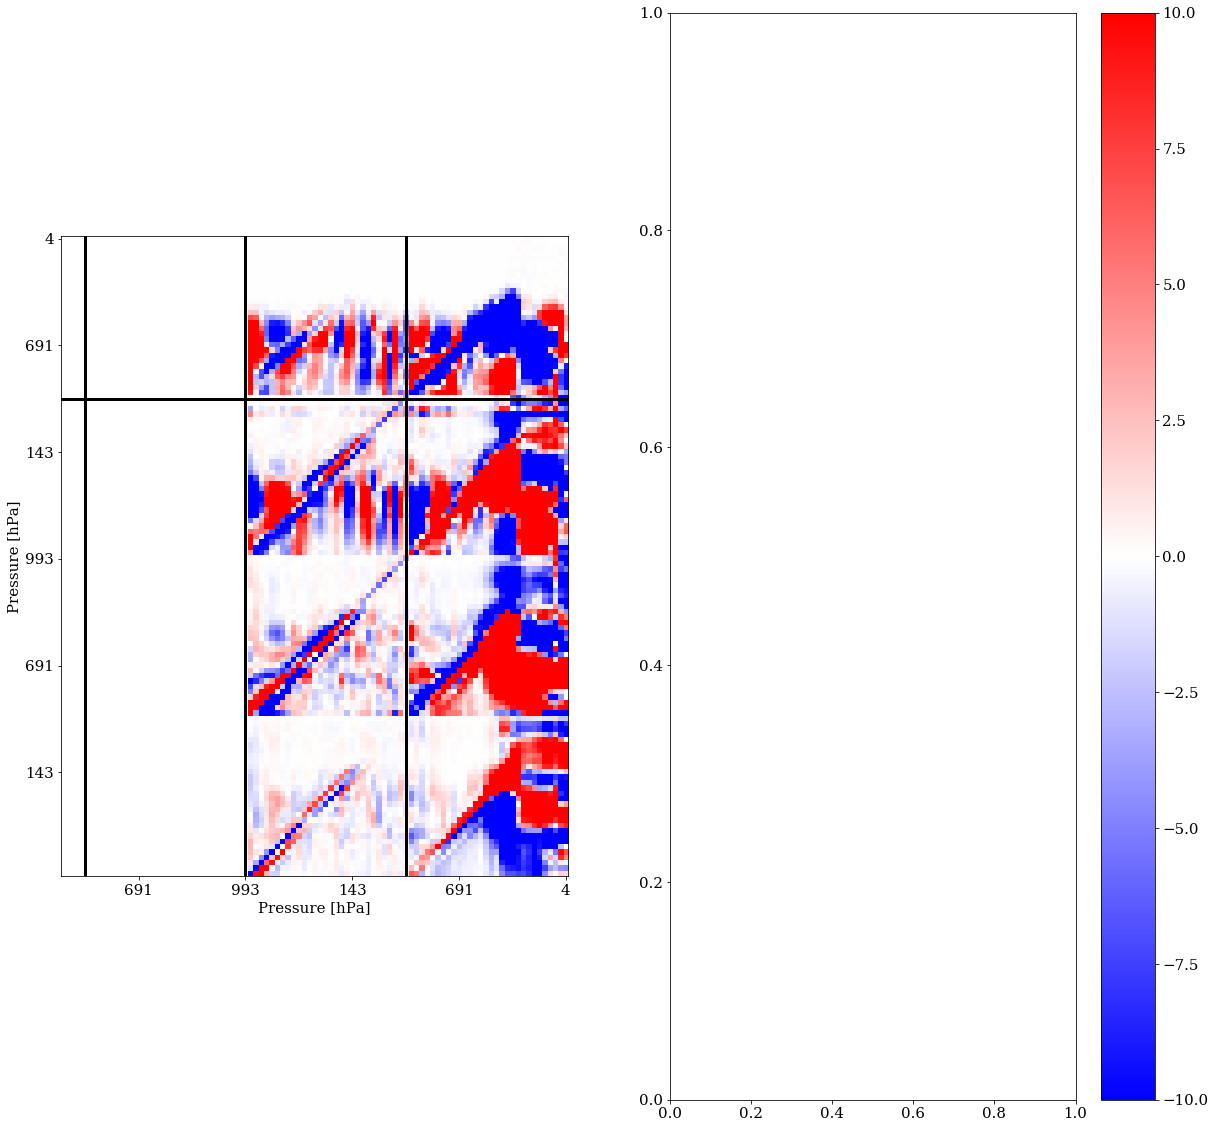

In [165]:
fig,ax = plt.subplots(1,2,figsize=(20,20))

toplot = weight['2021_04_26_MLR.hdf5'][:60,:120].T
#toplot = LRF_NORM['2021_04_26_MLR.hdf5'][:60,:120]

iax = 0

mapp = ax[iax].imshow(toplot,cmap='bwr',vmin=-10,vmax=10)
plt.colorbar(mapp)
ax[iax].invert_xaxis()
# ax[iax].set_title(tit)
ax[iax].axhline(y=30,color='k',linewidth=lw/2)
for iy,yline in enumerate([30,60,90]):
    ax[iax].axvline(x=yline,color='k',linewidth=lw/2)

plt.draw()
# Change y labels to pressure
labels = [item.get_text() for item in ax[iax].get_yticklabels()]
for ilab,lab in enumerate(labels):
    lab0 = int(float(lab.replace('−','-')))
    lab0 = int(lab0-30*np.floor(lab0/31))
    lab0 = min(29,max(0,lab0))
    if iax==0: labels[ilab]=str('%01.0f'%coor.lev[lab0])
    else: labels[ilab] = ''
ax[iax].set_yticklabels(labels)
# Change x labels to pressure
labels = [item.get_text() for item in ax[iax].get_xticklabels()]
for ilab,lab in enumerate(labels):
    lab0 = int(float(lab.replace('−','-')))
    lab0 = int(lab0-30*np.floor(lab0/31))
    lab0 = min(29,max(0,lab0))
    if iax==0: labels[ilab]=str('%01.0f'%coor.lev[lab0])
    else: labels[ilab] = ''
ax[iax].set_xticklabels(labels)

ax[iax].set_xlabel('Pressure [hPa]')
if iax==0: ax[iax].set_ylabel('Pressure [hPa]')

## Use arrows to indicate each variable

In [192]:
inp_select = np.concatenate((np.arange(10,30),np.arange(40,60)))

In [193]:
inp_select

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59])

In [194]:
out_select = np.concatenate((np.arange(10,30),np.arange(40,60),np.arange(70,90),np.arange(100,120)))

In [195]:
out_select

array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119])

In [196]:
outinp_select = np.meshgrid(inp_select,out_select)

In [224]:
mapp = {}

In [225]:
LRF['2021_04_26_MLR.hdf5'].shape

(64, 120)

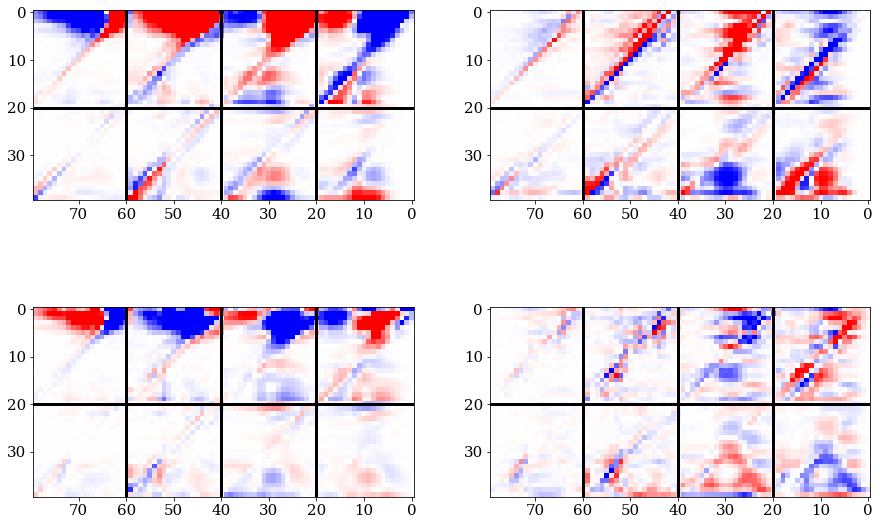

In [266]:
fig,ax = plt.subplots(2,2,figsize=(15,10))

for icol in range(2):
    for ilin in range(2):
    
        if ilin==0 and icol==0: 
            toplot = LRF['2021_04_26_MLR.hdf5'][tuple(outinp_select)].T
            VMIN = -0.5; VMAX = 0.5
        elif ilin==1 and icol==0: 
            toplot = (LRF['2021_04_27_W2C_MLR.hdf5'][tuple(outinp_select)].T-\
            LRF['2021_04_26_MLR.hdf5'][tuple(outinp_select)].T)
        elif ilin==0 and icol==1: 
            toplot = LRF['2021_06_17_MLR_RH_BMSE_LHF_nsDELQ.hdf5'][tuple(outinp_select)].T
            VMIN = -20; VMAX = 20;
        elif ilin==1 and icol==1: 
            toplot = (LRF['2021_06_17_MLR_RH_BMSE_LHF_nsDELQ.hdf5'][tuple(outinp_select)].T-\
            LRF['2021_06_17_W2C_MLR_RH_BMSE_LHF_nsDELQ.hdf5'][tuple(outinp_select)].T)

        mapp[icol] = ax[ilin][icol].imshow(toplot,cmap='bwr',vmin=VMIN,vmax=VMAX)
        ax[ilin][icol].invert_xaxis()
        ax[ilin][icol].axhline(y=20,color='k',linewidth=lw/2)
        for iy,yline in enumerate([20,40,60]):
            ax[ilin][icol].axvline(x=yline,color='k',linewidth=lw/2)

    # plt.draw()

In [251]:
INP_dic = ['p$_{s}$','S$_{0}$','SHF','LHF']

In [252]:
LRF['2021_04_26_MLR.hdf5'].shape

(64, 120)

In [256]:
COL = ['darkviolet','gold','forestgreen','royalblue']

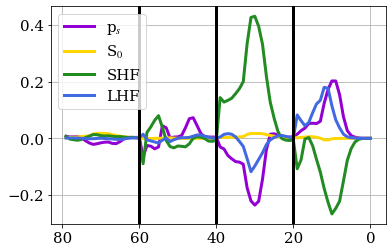

In [258]:
for iinp in np.arange(60,64):
    plt.plot(np.arange(0,80),LRF['2021_04_26_MLR.hdf5'][iinp,out_select],label=INP_dic[iinp-60],
             linewidth=lw/2,color=COL[iinp-60])
plt.legend()
plt.grid()
plt.gca().invert_xaxis()
for iy,yline in enumerate([20,40,60]):
    plt.axvline(x=yline,color='k',linewidth=lw/2)

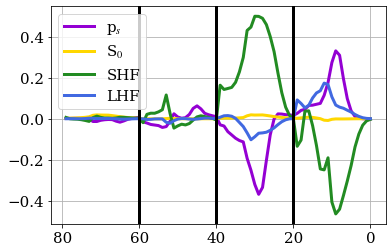

In [260]:
for iinp in np.arange(60,64):
    plt.plot(np.arange(0,80),LRF['2021_04_27_W2C_MLR.hdf5'][iinp,out_select],label=INP_dic[iinp-60],
             linewidth=lw/2,color=COL[iinp-60])
plt.legend()
plt.grid()
plt.gca().invert_xaxis()
for iy,yline in enumerate([20,40,60]):
    plt.axvline(x=yline,color='k',linewidth=lw/2)

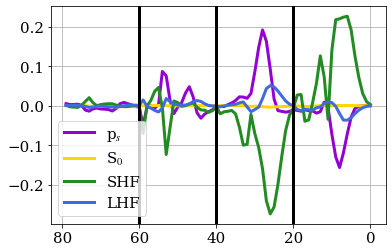

In [261]:
for iinp in np.arange(60,64):
    plt.plot(np.arange(0,80),LRF['2021_04_26_MLR.hdf5'][iinp,out_select]-\
             LRF['2021_04_27_W2C_MLR.hdf5'][iinp,out_select],
             label=INP_dic[iinp-60],linewidth=lw/2,color=COL[iinp-60])
plt.legend()
plt.grid()
plt.gca().invert_xaxis()
for iy,yline in enumerate([20,40,60]):
    plt.axvline(x=yline,color='k',linewidth=lw/2)

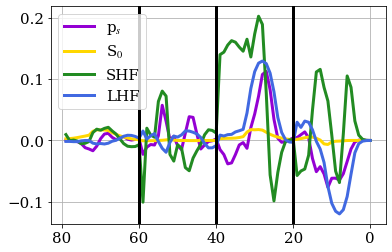

In [262]:
for iinp in np.arange(60,64):
    plt.plot(np.arange(0,80),LRF['2021_06_17_MLR_RH_BMSE_LHF_nsDELQ.hdf5'][iinp,out_select],label=INP_dic[iinp-60],
             linewidth=lw/2,color=COL[iinp-60])
plt.legend()
plt.grid()
plt.gca().invert_xaxis()
for iy,yline in enumerate([20,40,60]):
    plt.axvline(x=yline,color='k',linewidth=lw/2)

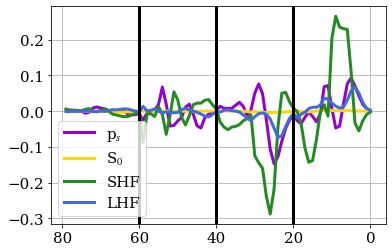

In [263]:
for iinp in np.arange(60,64):
    plt.plot(np.arange(0,80),LRF['2021_06_17_MLR_RH_BMSE_LHF_nsDELQ.hdf5'][iinp,out_select]-\
             LRF['2021_06_17_W2C_MLR_RH_BMSE_LHF_nsDELQ.hdf5'][iinp,out_select],label=INP_dic[iinp-60],
             linewidth=lw/2,color=COL[iinp-60])
plt.legend()
plt.grid()
plt.gca().invert_xaxis()
for iy,yline in enumerate([20,40,60]):
    plt.axvline(x=yline,color='k',linewidth=lw/2)

## Put all panels & arrows together (TODO once several MLR runs possible)

# SHAP